# Node properties
## Introduction
In this tutorial we will cover inspection of node (that is, cell) properties.

## Preamble
The code in this section is identical to the code in the sections from "Preamble" to "Properties and methods" from the previous tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import bluepysnap

# load the circuit and store the node population
circuit_path = "/gpfs/bbp.cscs.ch/project/proj30/hippocampus/single_column/sonata/struct_circuit_config.json"
circuit = bluepysnap.Circuit(circuit_path)
node_population = circuit.nodes["All"]
node_population.property_names

{'@dynamics:holding_current',
 '@dynamics:threshold_current',
 'etype',
 'layer',
 'model_template',
 'morph_class',
 'morphology',
 'mtype',
 'region',
 'rotation_angle_xaxis',
 'rotation_angle_yaxis',
 'rotation_angle_zaxis',
 'synapse_class',
 'x',
 'y',
 'z'}

## Node properties and methods
Node populations provide information about the collection of nodes, and what information is available for each of the nodes themselves.

Let's begin by retrieving all nodes with their associated layer, synapse type, and position in 3D space. We can then use this to understand how the synapse types are distributed between layers.

In [2]:
df_all = node_population.get(properties=['layer', 'synapse_class', 'x', 'y', 'z'])
df_all.groupby(['synapse_class', 'layer']).count()

x     y     z
synapse_class layer                  
EXC           SP     2427  2427  2427
INH           SLM      24    24    24
              SO       31    31    31
              SP      253   253   253
              SR      215   215   215

Let's now plot the positions of the synapses by type in the x-z plane.

In [3]:
df_all.head()

,layer,synapse_class,x,y,z
0,SLM,INH,10.672496,506.793928,134.536968
1,SLM,INH,51.832798,511.448478,24.880563
2,SLM,INH,107.851529,502.817301,-194.135898
3,SLM,INH,42.930203,518.489436,-73.821233
4,SLM,INH,-162.259527,503.331452,-109.188986


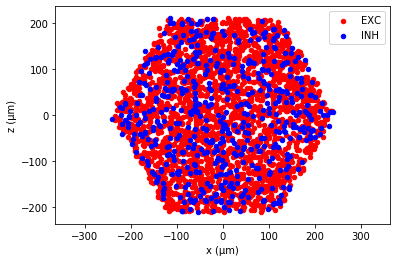

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1)

df_grouped = df_all.groupby('synapse_class')

for color, (name, group) in zip(('r', 'b'), df_grouped):
    group.plot(x='x', y='z', c=color, kind='scatter', ax=ax, label=name)

ax.axis('equal')
ax.set_xlabel(u'x (μm)')
ax.set_ylabel(u'z (μm)');

Now we will visualize the positions of nodes in each layer

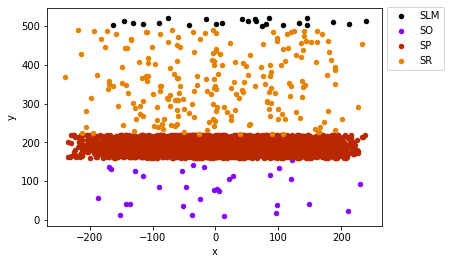

In [5]:
# get all cell positions and group by layer
df_all = node_population.get(properties=['x', 'y', 'z', 'layer'])
df_grouped = df_all.groupby('layer')

fig, ax = plt.subplots(nrows=1, ncols=1)
colors = cm.gnuplot(np.linspace(0.0, 0.8, len(df_grouped)))

for i, (name, group) in enumerate(df_grouped):
    group.plot(x='x', y='y', c=[colors[i]], kind='scatter', ax=ax, label=name)

ax.legend(bbox_to_anchor=(1.2, 1.03), loc="upper right");

Whilst retrieving all nodes may be useful, SONATA also uses the concept of predefined `node_sets`. These `node_sets` define collections of nodes (filtered by properties, ids, or other methods) which are named and stored in the SONATA output. You can retrieve all node sets in the population:

In [6]:
node_population.node_sets

{'All': {},
 'Excitatory': {'synapse_class': 'EXC'},
 'Inhibitory': {'synapse_class': 'INH'},
 'SLM_PPA': {'mtype': 'SLM_PPA'},
 'SO_BP': {'mtype': 'SO_BP'},
 'SO_BS': {'mtype': 'SO_BS'},
 'SO_OLM': {'mtype': 'SO_OLM'},
 'SO_Tri': {'mtype': 'SO_Tri'},
 'SP_AA': {'mtype': 'SP_AA'},
 'SP_BS': {'mtype': 'SP_BS'},
 'SP_CCKBC': {'mtype': 'SP_CCKBC'},
 'SP_Ivy': {'mtype': 'SP_Ivy'},
 'SP_PC': {'mtype': 'SP_PC'},
 'SP_PVBC': {'mtype': 'SP_PVBC'},
 'SR_SCA': {'mtype': 'SR_SCA'},
 'bAC': {'etype': 'bAC'},
 'cAC': {'etype': 'cAC'},
 'cACpyr': {'etype': 'cACpyr'},
 'cNAC': {'etype': 'cNAC'},
 'SLM': {'region': 'SLM'},
 'SO': {'region': 'SO'},
 'SP': {'region': 'SP'},
 'SR': {'region': 'SR'}}

Using the name of a `node_set`, it is possible to retrieve the specific subset of nodes:

In [7]:
df_SO = node_population.positions('SO')
df_SLM = node_population.positions('SLM')

Now we are able to plot the position of these cells in both the `x-z` and `x-y` planes:

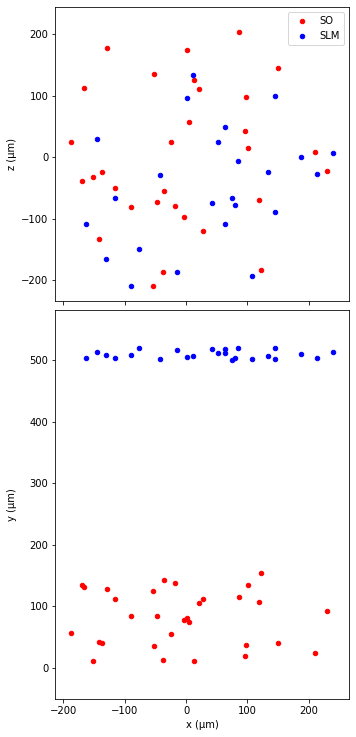

In [8]:
# stack the plots
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(5, 11))

df_SO.plot(x='x', y='z', color='r', kind='scatter', ax=axes[0])
df_SO.plot(x='x', y='y', color='r', kind='scatter', ax=axes[1])
df_SLM.plot(x='x', y='z', color='b', kind='scatter', ax=axes[0])
df_SLM.plot(x='x', y='y', color='b', kind='scatter', ax=axes[1])

axes[1].set_xlabel(u'x (μm)')
axes[1].set_ylabel(u'y (μm)');
axes[0].set_ylabel(u'z (μm)');
axes[0].legend(['SO', 'SLM'], numpoints=1)

# ensure consistent scale on all axes
axes[0].axis('square')
axes[1].axis('equal')

# tidy up formatting
fig.align_ylabels()
fig.tight_layout()
fig.subplots_adjust(hspace=-0.1)

Or, alternatively, as a 3D scatterplot.

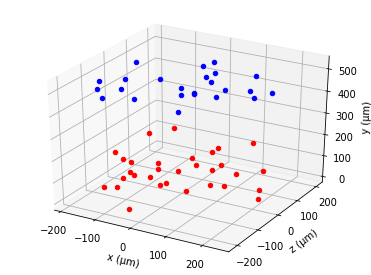

In [9]:
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(6.4, 4.8))
ax.scatter(df_SO.x, df_SO.z, df_SO.y, c="r", depthshade=False)
ax.scatter(df_SLM.x, df_SLM.z, df_SLM.y, c="b", depthshade=False)

ax.set_xlabel(u'x (μm)')
ax.set_ylabel(u'z (μm)')
ax.set_zlabel(u'y (μm)');

Let's also understand the different m-types in the node population:

In [10]:
node_population.property_values("mtype")

{'SLM_PPA',
 'SO_BP',
 'SO_BS',
 'SO_OLM',
 'SO_Tri',
 'SP_AA',
 'SP_BS',
 'SP_CCKBC',
 'SP_Ivy',
 'SP_PC',
 'SP_PVBC',
 'SR_SCA'}

## Conclusion
Now that we can inspect node properties, the following tutorial will cover retrieving edge properties.